EDA (Exploratory Data Analysis) på PhysioNet 2019 Sepsis (training_setA)

I den här notebooken gör jag en första utforskande analys av rådata (PSV-filer) för att förstå:

Hur långa patienttidslinjerna är (antal timmar / rader per patient)

Hur vanlig sepsis är (prevalens i urvalet)

Hur mycket saknade värden det finns (missingness) och vilka variabler som oftast saknas

Exempel på tidsserier för några patienter (för att se brus, luckor och typiska mönster)

Notebooken använder alltid samma “master”-mapp för rådata:
data/raw/physionet2019/training_setA/

Jag kan välja hur många patienter jag vill analysera genom att ändra N_PATIENTS (t.ex. 200 eller 5000).

Alla figurer sparas med konsekventa filnamn i:
outputs/figures/
så att jag kan inkludera dem i LaTeX-rapporten senare.

In [9]:
from google.colab import drive
drive.mount("/content/drive")

import os
import sys
import tensorflow as tf

PROJECT_DIR = "/content/drive/MyDrive/sepsis-timeline-project"
SRC_DIR = f"{PROJECT_DIR}/src"

os.chdir(PROJECT_DIR)

if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)

# 🔴 DENNA RAD ÄR VIKTIG
FIG_DIR = os.path.join(PROJECT_DIR, "outputs", "figures")
os.makedirs(FIG_DIR, exist_ok=True)

print("✅ Current working directory:", os.getcwd())
print("✅ FIG_DIR:", FIG_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Current working directory: /content/drive/MyDrive/sepsis-timeline-project
✅ FIG_DIR: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures


In [10]:
# ==================================
# Imports som behövs för EDA
# ==================================

import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [11]:
# =====================================================
# Välj hur många patienter som ska användas i EDA
# =====================================================

RAW_DIR = os.path.join(
    PROJECT_DIR,
    "data", "raw", "physionet2019", "training_setA"
)

# 🔽 ÄNDRA ENDAST DENNA RAD VID BEHOV
N_PATIENTS = 5000   # t.ex. 200 eller 5000

all_files = sorted(glob.glob(os.path.join(RAW_DIR, "p*.psv")))
files = all_files[:N_PATIENTS]

print("RAW_DIR:", RAW_DIR)
print("Totalt antal .psv i training_setA:", len(all_files))
print("Antal filer som används i EDA:", len(files))
print("Exempel:", os.path.basename(files[0]), "→", os.path.basename(files[-1]))


RAW_DIR: /content/drive/MyDrive/sepsis-timeline-project/data/raw/physionet2019/training_setA
Totalt antal .psv i training_setA: 5000
Antal filer som används i EDA: 5000
Exempel: p000001.psv → p005000.psv


In [12]:
# ==================================
# Hjälpfunktion för att läsa .psv-filer
# ==================================
# Filerna är pipe-separerade (|)

def read_psv(path: str) -> pd.DataFrame:
    return pd.read_csv(path, sep="|")


In [13]:
# ==================================
# Sanity check: läs första patientfilen
# ==================================

df0 = read_psv(files[0])
print("Shape (rader x kolumner):", df0.shape)
display(df0.head(5))


Shape (rader x kolumner): (54, 41)


,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,1,0
1,97.0,95.0,NaN,98.0,75.33,NaN,19.0,NaN,NaN,NaN,...,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,2,0
2,89.0,99.0,NaN,122.0,86.00,NaN,22.0,NaN,NaN,NaN,...,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,3,0
3,90.0,95.0,NaN,NaN,NaN,NaN,30.0,NaN,24.0,NaN,...,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,4,0
4,103.0,88.5,NaN,122.0,91.33,NaN,24.5,NaN,NaN,NaN,...,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,5,0


Antal patienter: 5000
Min / Median / Max längd: 8 38.0 336


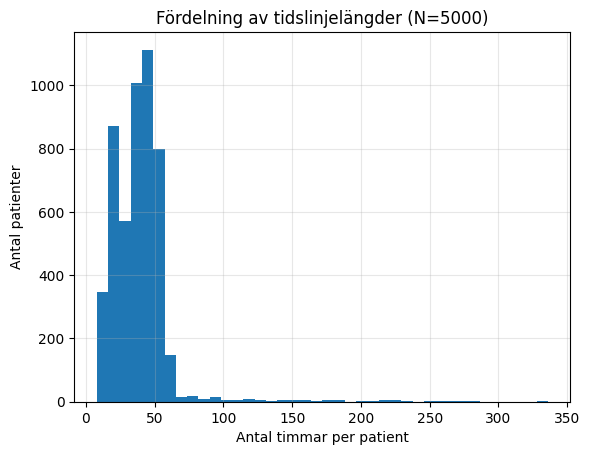

✅ Sparad figur: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/eda_timeseries_length_distribution.png


In [14]:
# =====================================================
# 1) Fördelning av tidslinjelängder (antal timmar)
# =====================================================

lengths = []

for fp in files:
    try:
        df = read_psv(fp)
        lengths.append(len(df))
    except Exception as e:
        print("Fel vid läsning:", os.path.basename(fp), e)

lengths = np.array(lengths)

print("Antal patienter:", len(lengths))
print("Min / Median / Max längd:", lengths.min(), np.median(lengths), lengths.max())

plt.figure()
plt.hist(lengths, bins=40)
plt.xlabel("Antal timmar per patient")
plt.ylabel("Antal patienter")
plt.title(f"Fördelning av tidslinjelängder (N={len(lengths)})")
plt.grid(True, alpha=0.3)

out_path = os.path.join(FIG_DIR, "eda_timeseries_length_distribution.png")
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()

print("✅ Sparad figur:", out_path)


Andel patienter med sepsis: 0.0892 (8.92%)


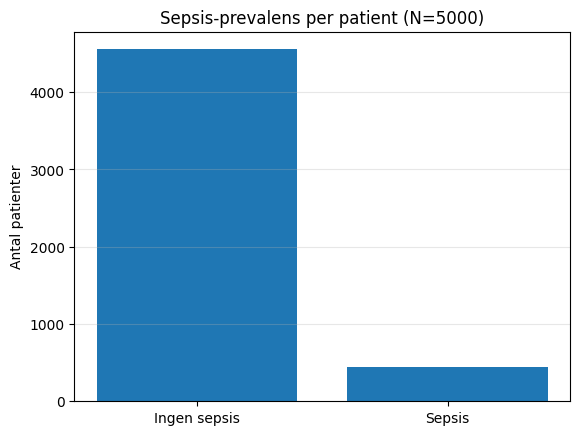

✅ Sparad figur: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/eda_sepsis_prevalence.png


In [15]:
# =====================================================
# 2) Sepsis-prevalens per patient
# =====================================================
# En patient räknas som "sepsis" om SepsisLabel = 1 någon gång

sepsis_patient = []

for fp in files:
    df = read_psv(fp)
    if "SepsisLabel" in df.columns:
        sepsis_patient.append(int(df["SepsisLabel"].fillna(0).max() >= 1))
    else:
        sepsis_patient.append(0)

sepsis_patient = np.array(sepsis_patient)
prevalence = sepsis_patient.mean()

print(f"Andel patienter med sepsis: {prevalence:.4f} ({prevalence*100:.2f}%)")

plt.figure()
plt.bar(
    ["Ingen sepsis", "Sepsis"],
    [len(sepsis_patient) - sepsis_patient.sum(), sepsis_patient.sum()]
)
plt.ylabel("Antal patienter")
plt.title(f"Sepsis-prevalens per patient (N={len(sepsis_patient)})")
plt.grid(True, axis="y", alpha=0.3)

out_path = os.path.join(FIG_DIR, "eda_sepsis_prevalence.png")
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()

print("✅ Sparad figur:", out_path)


Progress: 500/5000 filer
Progress: 1000/5000 filer
Progress: 1500/5000 filer
Progress: 2000/5000 filer
Progress: 2500/5000 filer
Progress: 3000/5000 filer
Progress: 3500/5000 filer
Progress: 4000/5000 filer
Progress: 4500/5000 filer
Progress: 5000/5000 filer


,missing_rate
EtCO2,1.000000
TroponinI,0.998773
Bilirubin_direct,0.998322
Fibrinogen,0.992178
Bilirubin_total,0.987949
Alkalinephos,0.985459
AST,0.985064
Lactate,0.964652
PTT,0.951775
Calcium,0.950933


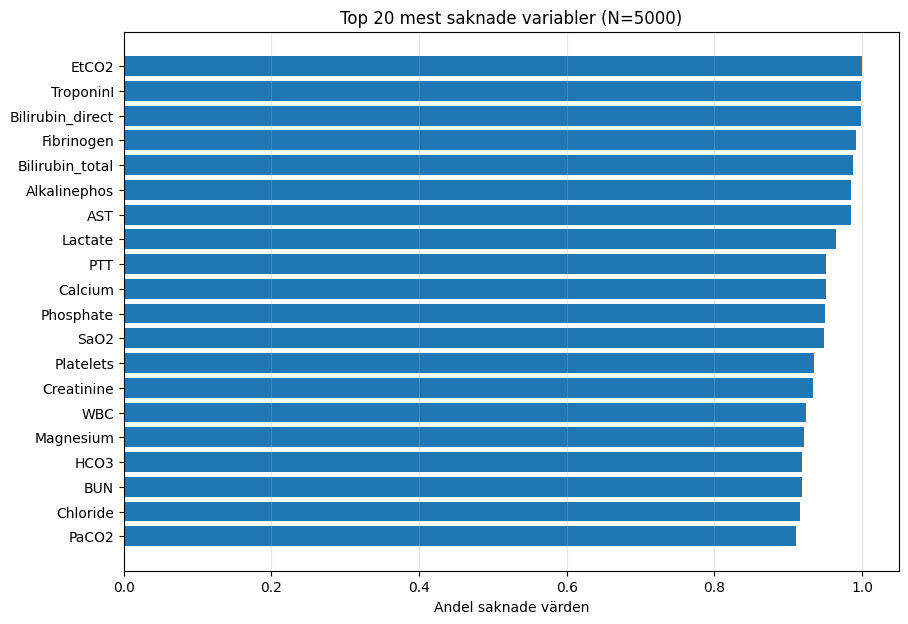

✅ Sparad figur: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/eda_missingness_top20.png


In [16]:
# =====================================================
# 3) Missingness: andel saknade värden per variabel
# =====================================================

missing_counts = None
total_counts = None
columns_ref = None

for i, fp in enumerate(files):
    df = read_psv(fp)

    if columns_ref is None:
        columns_ref = df.columns.tolist()
        missing_counts = pd.Series(0, index=columns_ref, dtype=np.int64)
        total_counts = pd.Series(0, index=columns_ref, dtype=np.int64)

    df = df.reindex(columns=columns_ref)

    missing_counts += df.isna().sum()
    total_counts += len(df)

    if (i + 1) % 500 == 0:
        print(f"Progress: {i+1}/{len(files)} filer")

missing_rate = (missing_counts / total_counts).sort_values(ascending=False)

display(missing_rate.head(10).to_frame("missing_rate"))

top20 = missing_rate.head(20)[::-1]

plt.figure(figsize=(10, 7))
plt.barh(top20.index, top20.values)
plt.xlabel("Andel saknade värden")
plt.title(f"Top 20 mest saknade variabler (N={len(files)})")
plt.grid(True, axis="x", alpha=0.3)

out_path = os.path.join(FIG_DIR, "eda_missingness_top20.png")
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()

print("✅ Sparad figur:", out_path)


Exempelpatient: p000009.psv
Plottade variabler: ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp']


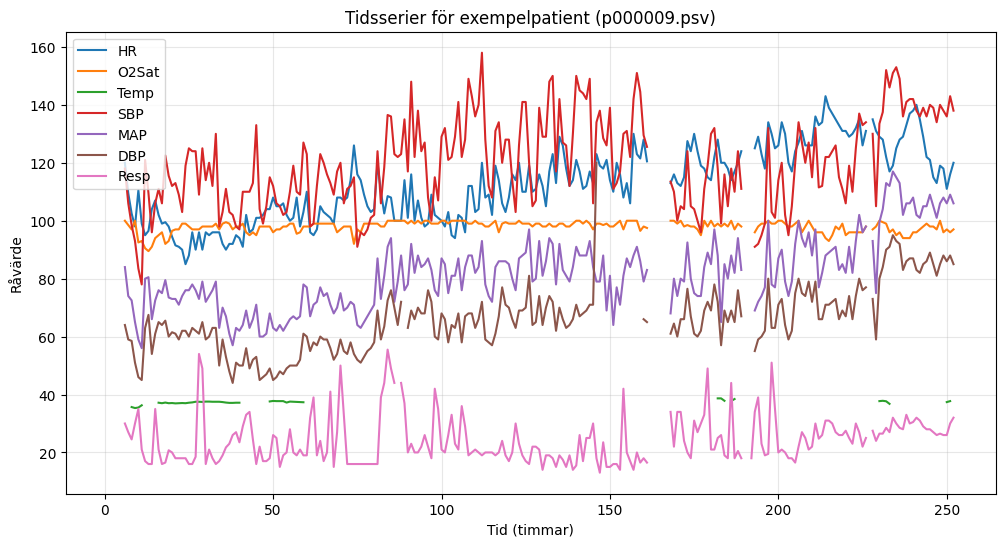

✅ Sparad figur: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/eda_timeseries_example_patient.png


In [17]:
# =====================================================
# 4) Exempel på tidsserier för en patient
# =====================================================

example_fp = None
for fp in files[:2000]:  # leta bland de första för snabbhet
    df = read_psv(fp)
    if "SepsisLabel" in df.columns and df["SepsisLabel"].fillna(0).max() >= 1:
        example_fp = fp
        break

if example_fp is None:
    example_fp = files[0]

df_ex = read_psv(example_fp)

candidate_features = ["HR", "O2Sat", "Temp", "SBP", "MAP", "DBP", "Resp"]
available = [c for c in candidate_features if c in df_ex.columns]

print("Exempelpatient:", os.path.basename(example_fp))
print("Plottade variabler:", available)

plt.figure(figsize=(12, 6))
for c in available:
    plt.plot(df_ex[c].values, label=c)

plt.xlabel("Tid (timmar)")
plt.ylabel("Råvärde")
plt.title(f"Tidsserier för exempelpatient ({os.path.basename(example_fp)})")
plt.grid(True, alpha=0.3)
plt.legend()

out_path = os.path.join(FIG_DIR, "eda_timeseries_example_patient.png")
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()

print("✅ Sparad figur:", out_path)


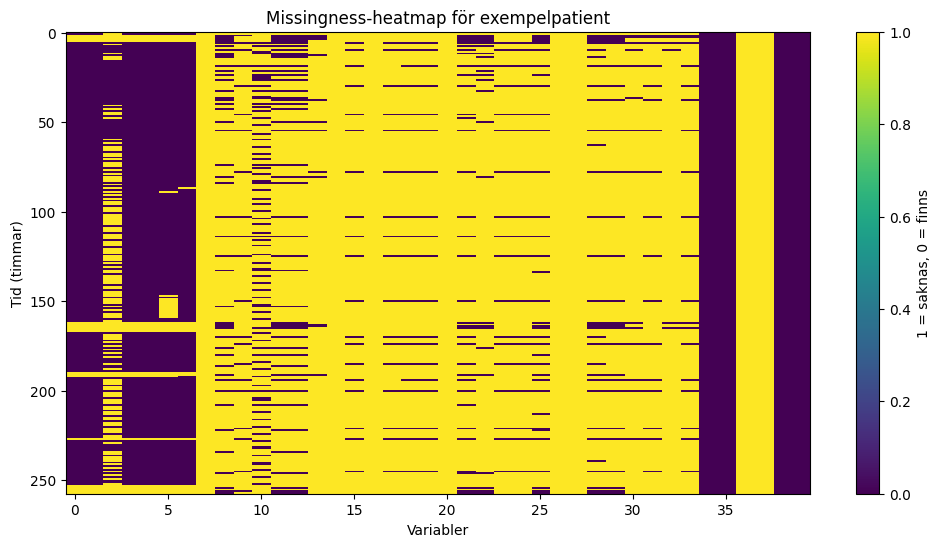

✅ Sparad figur: /content/drive/MyDrive/sepsis-timeline-project/outputs/figures/eda_missingness_heatmap_example_patient.png


In [18]:
# =====================================================
# 5) Missingness-heatmap för exempelpatient
# =====================================================

df_small = df_ex.iloc[:, :40]  # begränsa antal kolumner så figuren blir läsbar
miss_matrix = df_small.isna().astype(int).values

plt.figure(figsize=(12, 6))
plt.imshow(miss_matrix, aspect="auto", interpolation="nearest")
plt.colorbar(label="1 = saknas, 0 = finns")
plt.xlabel("Variabler")
plt.ylabel("Tid (timmar)")
plt.title("Missingness-heatmap för exempelpatient")

out_path = os.path.join(FIG_DIR, "eda_missingness_heatmap_example_patient.png")
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()

print("✅ Sparad figur:", out_path)


### Kort EDA-sammanfattning

- Jag analyserade `N_PATIENTS` patienter från `training_setA`.
- Patienttidslinjerna varierar kraftigt i längd, vilket motiverar fönsterindelning
  och/eller padding i senare modeller.
- Sepsis är relativt ovanligt på patientnivå, vilket innebär ett obalanserat
  klassificeringsproblem.
- Många laboratorievariabler har mycket hög missingness, vilket gör robust
  preprocessing (forward-fill, median-imputering och mask-kanaler) nödvändig.

Sparade figurer (för rapporten):
- `eda_timeseries_length_distribution.png`
- `eda_sepsis_prevalence.png`
- `eda_missingness_top20.png`
- `eda_timeseries_example_patient.png`
- `eda_missingness_heatmap_example_patient.png`